In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import Video

In [16]:
!pip install swig
!pip install gymnasium[box2d]
!pip install gymnasium[other]

In [17]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

env = gym.wrappers.RecordVideo(env, 
                               video_folder="./savevideos", 
                               disable_logger=True,
                               name_prefix="sample")

# Play game with random actions
done = False
_ = env.reset(seed=42)
while not done:
    state, reward, done, _, _ = env.step(env.action_space.sample())
env.close()

Video("savevideos/sample-episode-0.mp4", embed=True)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /kaggle/working/savevideos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


In [18]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
observation, _ = env.reset()

print(observation)

[-0.00513887  1.4103504  -0.520527   -0.02533693  0.00596144  0.11790711
  0.          0.        ]


### Actions
0: do nothing\
1: fire left engine\
2: fire main engine\
3: fire right engine

In [19]:
env.action_space

Discrete(4)

In [20]:
class DQN(nn.Module):
    """Deep Q-Network with 3 fully connected layers and ReLU activations."""
    def __init__(self,
                 input_state=8,
                 hidden_units=128,
                 num_actions=4):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(input_state, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, num_actions)

    def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [21]:
class ReplayBuffer:
    """Manages replay memory for training."""

    def __init__(self, max_memories, num_state_features=8):
        """
        Args:
            max_memories (int): Maximum number of memories to store.
            num_state_features (int): Number of features in the state. Defaults to 8.
        """
        self.max_memories = max_memories
        self.current_memories_ctr = 0

        # Buffers for states and next states
        self.state_memories = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)
        self.next_state_memories = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)

        # Buffer for actions
        self.action_memories = torch.zeros((self.max_memories,), dtype=torch.int64)

        # Buffer for rewards
        self.reward_memories = torch.zeros((self.max_memories,), dtype=torch.float32)

        # Buffer for terminal flags (game over)
        self.terminal_memories = torch.zeros((self.max_memories, ), dtype=torch.bool)

    def add_memories(self, state, next_state, action, reward, terminal):
        idx = self.current_memories_ctr % self.max_memories

        self.state_memories[idx] = torch.tensor(state, dtype=self.state_memories.dtype)
        self.next_state_memories[idx] = torch.tensor(next_state, dtype=self.next_state_memories.dtype)
        self.action_memories[idx] = torch.tensor(action, dtype=self.action_memories.dtype)
        self.reward_memories[idx] = torch.tensor(reward, dtype=self.reward_memories.dtype)
        self.terminal_memories[idx] = torch.tensor(terminal, dtype=self.terminal_memories.dtype)
        
        self.current_memories_ctr+=1

    def access_memory(self, batch_size, device='cpu'):
        total_memories = min(self.current_memories_ctr, self.max_memories)

        if total_memories < batch_size:
            return None

        rand_sample_idx = np.random.choice(np.arange(total_memories), size=batch_size, replace=False)
        rand_sample_idx = torch.tensor(rand_sample_idx, dtype=torch.long)

        batch = {
            "states": self.state_memories[rand_sample_idx].to(device),
            "next_states": self.next_state_memories[rand_sample_idx].to(device),
            "actions": self.action_memories[rand_sample_idx].to(device),
            "rewards": self.reward_memories[rand_sample_idx].to(device),
            "terminal": self.terminal_memories[rand_sample_idx].to(device)
        }

        return batch

### Agent

In [22]:
class Agent:
    def __init__(self,
                 num_actions,
                 max_memories=100_000,
                 gamma=0.99,
                 lr=0.001,
                 input_state_features=8,
                 hidden_features=128,
                 epsilon=1.0,
                 epsilon_decay=0.999,
                 min_epsilon=0.05,
                 device='cpu'):

        self.num_actions=num_actions
        self.max_memories = max_memories
        self.gamma=gamma
        self.lr=lr
        self.input_state_features=input_state_features
        self.hidden_features=hidden_features
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.min_epsilon=min_epsilon
        self.device=device

        # DQ Network
        self.DQN=DQN(self.input_state_features, self.hidden_features).to(self.device)

        # Initialize the target network to stabilize training by addressing the moving target problem
        self.DQN_NEXT=DQN(self.input_state_features, self.hidden_features).to(device)
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())
        self.DQN_NEXT.eval()

        # Adam Optimizer
        self.optimizer=optim.Adam(self.DQN.parameters(), lr=self.lr)

        # MSE Loss
        self.loss_fn=nn.MSELoss()

        self.replay_buffer=ReplayBuffer(self.max_memories, self.input_state_features)

    
    def select_action(self, state):

        if not isinstance(state, torch.Tensor):
            state=torch.tensor(state, device=self.device)

        # Create batch dim if not
        if state.dim() == 1:
            state=state.unsqueeze(0)

        assert state.shape[-1]==self.input_state_features, f"Passing {state.shape[-1]} features, expect {self.input_state_features}"

        # Epsilon Greedy selection
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.num_actions)

        else:
            self.DQN.eval()
            with torch.no_grad():
                Q_sa=self.DQN(state)
            action=torch.argmax(Q_sa).item()
            self.DQN.train()

        return action

    def update_epsilon(self):
        self.epsilon=max(self.min_epsilon, self.epsilon*self.epsilon_decay)

    # Function to update Target network after few steps
    def update_target_network(self):
        self.DQN_NEXT.load_state_dict(self.DQN.state_dict())

    def inference(self, state, device='cpu'):
        self.DQN = self.DQN.to(device)
        self.DQN.eval()

        with torch.no_grad():
            Q_sa=self.DQN(state.to(device))

        return torch.argmax(Q_sa).item()


    def train_step(self, batch_size):
        batch=self.replay_buffer.access_memory(batch_size, self.device)

        if batch is None:
            return None

        # (B x Actions)
        q_estimate=self.DQN(batch["states"])
        
        q_estimate=torch.gather(q_estimate, index=batch["actions"].unsqueeze(-1), dim=-1).squeeze(-1)
      
        with torch.no_grad():
            self.DQN.eval()
            # Use Target Network
            q_next_estimate=self.DQN_NEXT(batch["next_states"])
            self.DQN.train()
    
        max_q_estimate=torch.max(q_next_estimate, dim=-1).values
    
        td_target=batch["rewards"] + self.gamma*max_q_estimate * (~batch["terminal"])

            
        # We want to move our model outputs (q_estimate) close to TD targets
        loss=self.loss_fn(td_target, q_estimate)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Updating epsilon
        self.update_epsilon()



### Trainer

In [23]:
def trainer(env, 
            num_games=500,
            min_reward=200,
            game_tolerance=10,
            max_memories=100_000,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            input_state_features=8,
            num_actions=4,
            hidden_features=128,
            epsilon=1.0,
            epsilon_decay=0.999,
            min_epsilon=0.05,
            log_freq=50,
            running_avg_steps=25,
            update_target_freq=100,
            device="cpu"):

    agent=Agent(max_memories=max_memories,
                gamma=gamma,
                lr=lr, 
                input_state_features=input_state_features,
                num_actions=num_actions,
                hidden_features=hidden_features,
                epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                min_epsilon=min_epsilon,
                device=device)

    ending_tol=0

    log={"scores": [],
         "running_avg_scores": []}

    for i in range(num_games):

        score = 0
        step = 0

        state, _ = env.reset()
        done = False

        while not done:
            action = agent.select_action(state)

            next_state, reward, terminal, truncated, _ = env.step(action)
            done  = terminal or truncated

            score += reward

            agent.replay_buffer.add_memories(state, next_state, action, reward, done)

            agent.train_step(batch_size)

            # Update target Network after some steps
            if step%update_target_freq==0:
                agent.update_target_network()
                # print("Target network updated")

            step+=1

            state = next_state

        log["scores"].append(score)
        running_avg_scores = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg_scores)
        
        if i%log_freq==0:
            print(f"Game: {i} | Score: {score} | Moving avg scores: {running_avg_scores} | Epsilon: {agent.epsilon}")

        if score >= min_reward:
            ending_tol += 1

            if ending_tol == game_tolerance:
                break
 
        else:
            ending_tol=0 


    print("Complete Training")

    return agent, log


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
agent, log = trainer(
    env,
    num_games=500,
    batch_size=128,
    hidden_features=256,
    epsilon_decay=0.9995,
    gamma=0.99,
    lr=0.0005,
    device=device,
)

cuda
Game: 0 | Score: -139.37748019180384 | Moving avg scores: -139.37748019180384 | Epsilon: 1.0
Game: 50 | Score: -183.5506045992279 | Moving avg scores: -87.03134522327082 | Epsilon: 0.05
Game: 100 | Score: -78.79208304255982 | Moving avg scores: 56.315431071375016 | Epsilon: 0.05
Game: 150 | Score: 247.31940647780743 | Moving avg scores: 191.3267248240627 | Epsilon: 0.05
Game: 200 | Score: 33.136832697000244 | Moving avg scores: 191.37812249605653 | Epsilon: 0.05
Complete Training


In [25]:
def record_game(env, agent, prefix, device="cpu"):
    env = gym.wrappers.RecordVideo(env, 
                                   video_folder='./save_videos',
                                   video_length=0,
                                   disable_logger=True,
                                   name_prefix=prefix)
    
    done = False
    state, _ = env.reset()

    while not done:
        action = agent.inference(torch.tensor(state), device=device)

        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate

        state = new_state

    env.close()


In [29]:
record_game(env, agent, prefix="q_learning_stable")

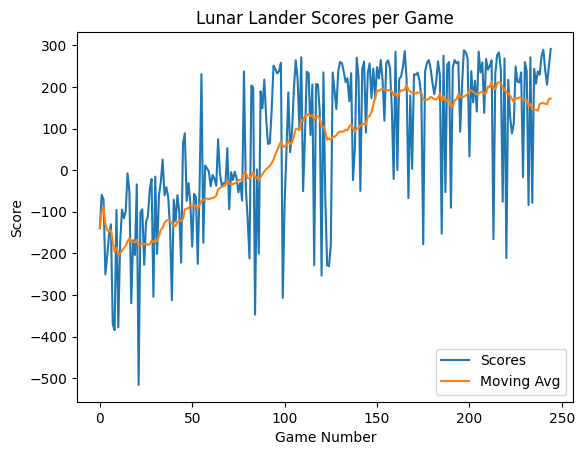

In [27]:
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()